In [121]:
import pandas as pd
import bz2
import json
import re
import math
import pickle
import statistics as stat
import matplotlib.pyplot as plt
import numpy as np
import time
import string
#!pip install langdetect
from langdetect import detect

import seaborn as sns
import fastcluster
#conda install -c conda-forge fastcluster

#NLP libraries
#pip install -U spacy
#python -m spacy download en_core_web_sm
import nltk, spacy, sklearn
from spacy.lang.en import English

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#pip install vaderSentiment


nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/paulmoreau/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [122]:
Path = "../data/Pope-quotes.pkl"
file = open(Path,'rb')
df = pickle.load(file)

# Pre-processing

In [123]:
pre_processed_df = df.copy()

#modify the types of the probabilities (from Object to float)
pre_processed_df['probability'] = pre_processed_df['probability'].astype(np.float)
pre_processed_df['second_probability'] = pre_processed_df['second_probability'].astype(np.float)
pre_processed_df['third_probability'] = pre_processed_df['third_probability'].astype(np.float)
pre_processed_df

,quote,speaker,probability,second_speaker,second_probability,third_speaker,third_probability,date,nbr_occurences,phase,nbr_words,nbr_characters,nbr_speakers
0,"a good father knows how to wait, and knows how...",Pope Francis,0.7727,None,0.2215,Thomas Rosica,0.0058,2015-02-06 15:31:07,2,E,18,87,3
1,"I don't have an ear for it,",Pope Francis,0.7834,None,0.1408,Mark Miles,0.0758,2015-09-25 01:44:00,1,E,8,27,3
2,Ask `What does this say to my heart? What is G...,Pope Francis,0.9272,None,0.0728,NaN,NaN,2015-12-03 21:20:49,1,E,17,82,2
3,"Be praised, my Lord, through our sister Mother...",Pope Francis,0.7581,None,0.2419,NaN,NaN,2015-06-19 00:49:49,1,E,24,137,2
4,But he's already taken a number of important s...,Pope Francis,0.5039,None,0.4961,NaN,NaN,2015-07-28 19:34:53,2,E,20,103,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102988,the Gospel of Jesus Christ is the greatest jus...,Pope Francis,0.8534,None,0.1466,NaN,NaN,2020-03-11 15:05:20,1,E,33,165,2
102989,"from the bishop to the foreigner, from the pri...",Pope Francis,0.7182,None,0.2818,NaN,NaN,2020-01-17 16:07:41,1,E,46,278,2
102990,"`saw the son coming from afar,' that son who h...",Pope Francis,0.7372,None,0.2628,NaN,NaN,2020-03-20 13:13:06,1,E,20,96,2
102991,This prayer of the Angelus today is a little s...,Pope Francis,0.7234,None,0.2766,NaN,NaN,2020-03-08 20:57:39,1,E,28,125,2


## Tokenization

Filtering the total lists of words to obtain a list of unique words with their according frequency in the dataset (-> words_freq). Removal of all the common words to obtain a more relevant list of the words used, to study the lexical fields

In [5]:
# Tokenization to isolate each words of each quote

start_time = time.time()
pre_processed_df['tokenized'] = pre_processed_df.apply(lambda row: nltk.word_tokenize(row['quote']), axis=1)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
pre_processed_df['tokenized_text'] = df['quote'].apply(word_tokenize) 
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
tt = TweetTokenizer()
pre_processed_df['tokenized_text_tweet'] = pre_processed_df['quote'].apply(tt.tokenize)
print("--- %s seconds ---" % (time.time() - start_time))



--- 19.961794137954712 seconds ---
--- 22.181391954421997 seconds ---
--- 9.366783142089844 seconds ---


In [45]:
# compute the frequency of each words
total_words = pd.DataFrame(np.concatenate(pd.concat([pre_processed_df['tokenized']], axis = 0)),columns=['word'])
words_freq = total_words.value_counts().rename_axis('word').reset_index(name='nbr_occurence')


In [49]:
score = len(words_freq)/len(pre_processed_df)
print(score)

24.9229850572369


In [11]:
# removal of all stop words and punctuation 
stop_words = stopwords.words('english')
stop_words.extend(spacy.lang.en.stop_words.STOP_WORDS)
stop_words.extend([singer.capitalize() for singer in stop_words]) #stop words with capitale
stop_words.extend(list(string.punctuation))

new_words_freq = words_freq[~words_freq['word'].isin(stop_words)] #remove stop words and punctuation
print(total_words[:50])

#words with 2 or less characters
small_words = new_words_freq.loc[new_words_freq['word'].str.len() <= 2]

       word
0         a
1      good
2    father
3     knows
4       how
5        to
6      wait
7         ,
8       and
9     knows
10      how
11       to
12  forgive
13     from
14      the
15   bottom
16       of
17      his
18    heart
19        .
20        I
21       do
22      n't
23     have
24       an
25      ear
26      for
27       it
28        ,
29      Ask
30        `
31     What
32     does
33     this
34      say
35       to
36       my
37    heart
38        ?
39     What
40       is
41      God
42   saying
43       to
44       me
45  through
46    these
47    words
48        ?
49       Be


change n in 'len() >= n' to decide which words you want to see. Filter useful beacause most recurrent words are: that, or, etc...

In [12]:
mask = (total_words['word'].str.len() >= 8)
total_words = total_words.loc[mask]

In [13]:
frequency = total_words.word.value_counts()[0:30]
print(frequency)

children       3194
Christian      2431
violence       2042
brothers       1972
ourselves      1679
together       1633
dialogue       1611
Christians     1545
community      1535
families       1509
everyone       1502
something      1440
suffering      1417
especially     1416
humanity       1373
religious      1372
everything     1368
important      1262
encounter      1117
themselves     1105
different      1093
Catholic       1087
forgiveness    1077
spiritual      1026
solidarity     1008
understand      966
political       962
experience      916
faithful        915
continue        869
Name: word, dtype: int64


In [14]:
np.where(len(total_words.word) >= 4 )

(array([0]),)

## Language filtering

In [ ]:
index = []

for n, quote_ in enumerate(pre_processed_df['quote']) :
    
    value = detect(quote_)
    
    if value != "en":
        #language.append(value)
        #pre_processed_df.drop(n)
        index.append(n)
    
pre_processed_df.drop(index, inplace=True)

print("Percentage of non english quotes that were removed :", (len(df)-len(pre_processed_df))/len(df)*100)


## First speaker probability filtering

Text(0, 0.5, 'number of quotes')

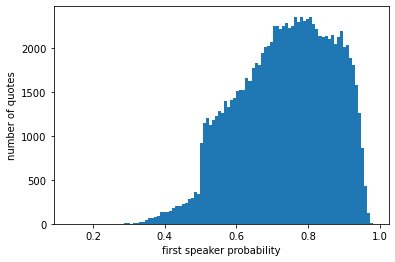

In [133]:
_=plt.hist(pre_processed_df.probability,bins=100)
plt.xlabel('first speaker probability')
plt.ylabel('number of quotes')

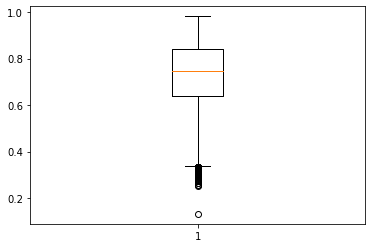

In [129]:
_=plt.boxplot(pre_processed_df.probability)

In [130]:
pre_processed_df.probability.describe()

count    102993.000000
mean          0.735559
std           0.131016
min           0.132500
25%           0.639800
50%           0.746200
75%           0.842200
max           0.981800
Name: probability, dtype: float64

Text(0, 0.5, 'number of quotes')

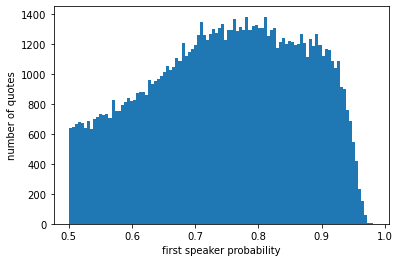

In [134]:
processed_df = pre_processed_df.copy()
processed_df.drop(processed_df.query('probability <= 0.5').index, inplace=True)

_=plt.hist(processed_df.probability,bins=100)
plt.xlabel('first speaker probability')
plt.ylabel('number of quotes')

## Analysis of second and third speakers
Reccurences of 20 most confused second/third speakers with the Pope:

In [16]:
check = pre_processed_df.copy().dropna()
aaa = check[['second_speaker', 'third_speaker']].stack()
aaa.value_counts()[0:30]

None                                         26332
John Paul                                     2053
President Donald Trump                         715
Donald Trump                                   615
Thomas D. Williams                             430
Benedict XVI                                   395
President Barack Obama                         310
President Trump                                299
Pietro Parolin                                 289
Pope Benedict XVI                              287
Oscar Romero                                   245
Federico Lombardi                              244
President Obama                                239
Theodore McCarrick                             196
Fernando Karadima                              185
Kim Davis                                      155
George Pell                                    150
Carlo Maria Vigano                             141
Abraham Lincoln                                136
Juan Carlos                    

Observations:  We can see couple of Pope Francis predescessors (John Paul, Benedict XVI) and other figures related to the catholic church (Pietro Parolin or Oscar Romero). In total, Trump has 715+615+299 = 1629 quotes which makes him the second most probable confusion with Pope (based on number of occurences). Moreover there is regular association with Barack Obama

I will now try to assemble a same entity under a unique name for Obama (in Barack Obama) and Trump (in Donald Trump) without the term "President" as they didn't always have this title in the 2015-2021 time frame. (here done manually but could try with np.where() ?

In [17]:
check.loc[check.second_speaker == "President Donald Trump", 'second_speaker'] = "Donald Trump"
check.loc[check.second_speaker == "President Trump", 'second_speaker'] = "Donald Trump"
check.loc[check.third_speaker == "President Donald Trump", 'third_speaker'] = "Donald Trump"
check.loc[check.third_speaker == "President Trump", 'third_speaker'] = "Donald Trump"

In [18]:
aaa = check[['second_speaker', 'third_speaker']].dropna().stack()
aaa.value_counts()[0:30]

None                                         26332
John Paul                                     2053
Donald Trump                                  1629
Thomas D. Williams                             430
Benedict XVI                                   395
President Barack Obama                         310
Pietro Parolin                                 289
Pope Benedict XVI                              287
Oscar Romero                                   245
Federico Lombardi                              244
President Obama                                239
Theodore McCarrick                             196
Fernando Karadima                              185
Kim Davis                                      155
George Pell                                    150
Carlo Maria Vigano                             141
Abraham Lincoln                                136
Juan Carlos                                    132
Matteo Salvini                                 121
Carlo Maria Viganò             

# First descriptive analysis

count    102993.000000
mean         22.008069
std          18.410210
min           2.000000
25%          10.000000
50%          17.000000
75%          29.000000
max         419.000000
Name: nbr_words, dtype: float64
22.008068509510355
<class 'pandas.core.series.Series'>


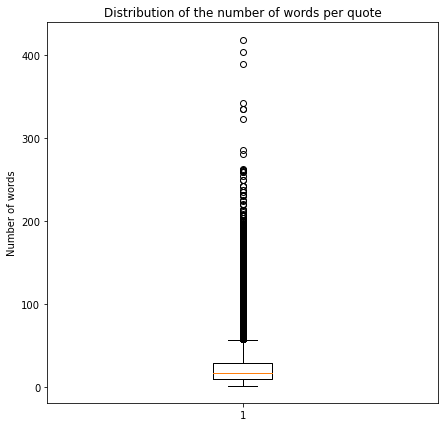

In [43]:
#statistics about the number of words 
nbr_words = pre_processed_df['nbr_words'].copy()

a = nbr_words.describe()
print(a)
print(a.loc['mean'])
print(type(pre_processed_df['nbr_words']))

plt.figure(figsize=(7, 7))
plt.boxplot(nbr_words)
plt.title("Distribution of the number of words per quote")
_=plt.ylabel('Number of words')

count    102993.000000
mean        123.302021
std         103.404912
min          12.000000
25%          53.000000
50%          97.000000
75%         161.000000
max        2408.000000
Name: nbr_characters, dtype: float64


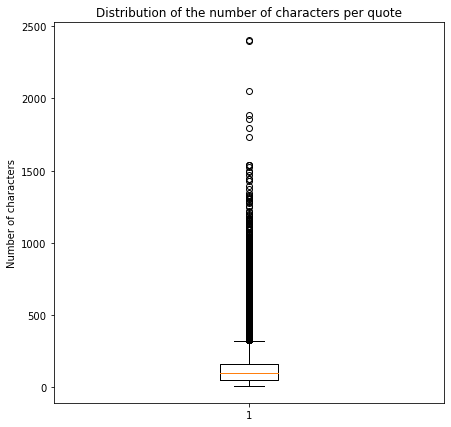

In [31]:
#statistics about the number of characters 
nbr_char = pre_processed_df['nbr_characters'].copy()

print(nbr_char.describe())

plt.figure(figsize=(7, 7))
plt.boxplot(nbr_char)
plt.title("Distribution of the number of characters per quote")
_=plt.ylabel('Number of characters')

count    102993.000000
mean          7.132592
std          39.712437
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        2657.000000
Name: nbr_occurences, dtype: float64


Text(0.5, 0, 'Log of number of occurences')

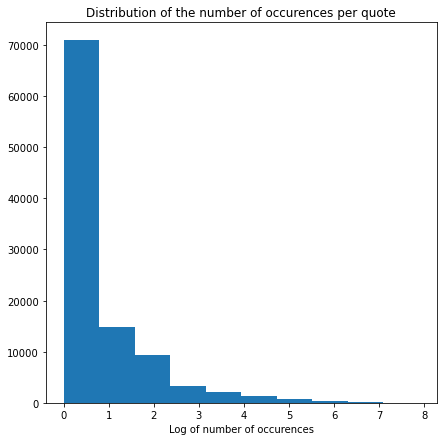

In [29]:
# Statistics about the number of occurences of each quote
nbr_occurences = pre_processed_df['nbr_occurences'].copy()

print(nbr_occurences.describe())

log_occ = np.log(nbr_occurences)
histo_occurences = log_occ.hist(figsize=(7,7), grid = False)

plt.title("Distribution of the number of occurences per quote")
plt.xlabel('Log of number of occurences')

In [22]:
# Most quoted sentence and its information

most_quoted = pre_processed_df.iloc[pre_processed_df['nbr_occurences'].idxmax()]
print(most_quoted['quote'])
print("")
print(most_quoted)

A person who thinks only about building walls -- wherever they may be -- and not building bridges, is not Christian,

quote                   A person who thinks only about building walls ...
speaker                                                      Pope Francis
probability                                                        0.5719
second_speaker                                                       None
second_probability                                                 0.2975
third_speaker                                                Donald Trump
third_probability                                                  0.0843
date                                                  2016-02-18 00:00:00
nbr_occurences                                                       2657
phase                                                                   E
nbr_words                                                              19
nbr_characters                                                      

In [23]:
# Top 10 of the most quoted sentences

ten_most_quoted = pre_processed_df.nlargest(10,'nbr_occurences')
mean_prob = (pre_processed_df['probability'].astype(np.float)).mean()
mean_10_prob = (ten_most_quoted['probability'].astype(np.float)).mean()

print("The mean probability that Pope Francis is the speaker of the 10th most quoted sentences is = ", round(mean_10_prob,4)*100, "% while the total probability mean is ", round(mean_prob,4)*100, "%")
print('')     
ten_most_quoted
      

The mean probability that Pope Francis is the speaker of the 10th most quoted sentences is =  66.66 % while the total probability mean is  73.56 %



,quote,speaker,probability,second_speaker,second_probability,third_speaker,third_probability,date,nbr_occurences,phase,nbr_words,nbr_characters,nbr_speakers,tokenized,tokenized_text,tokenized_text_tweet
36955,A person who thinks only about building walls ...,Pope Francis,0.5719,None,0.2975,Donald Trump,0.0843,2016-02-18 00:00:00,2657,E,19,116,46,"[A, person, who, thinks, only, about, building...","[A, person, who, thinks, only, about, building...","[A, person, who, thinks, only, about, building..."
8993,immense pile of filth.,Pope Francis,0.7237,None,0.2217,Fernando Vergara,0.0343,2015-06-16 07:05:00,2581,E,4,22,37,"[immense, pile, of, filth, .]","[immense, pile, of, filth, .]","[immense, pile, of, filth, .]"
1001,Let us treat others with the same passion and ...,Pope Francis,0.7165,None,0.2783,Abraham Lincoln,0.0015,2015-09-24 00:18:31,2127,E,17,90,8,"[Let, us, treat, others, with, the, same, pass...","[Let, us, treat, others, with, the, same, pass...","[Let, us, treat, others, with, the, same, pass..."
2124,"one of America's most precious possessions,",Pope Francis,0.6196,None,0.2907,President Barack Obama,0.0747,2015-09-23 00:00:00,1883,E,7,43,13,"[one, of, America, 's, most, precious, possess...","[one, of, America, 's, most, precious, possess...","[one, of, America's, most, precious, possessio..."
45085,strongly deplored the unacceptable massacre.,Pope Francis,0.6307,None,0.3451,President Donald Trump,0.0087,2017-04-05 00:00:00,1732,E,5,44,14,"[strongly, deplored, the, unacceptable, massac...","[strongly, deplored, the, unacceptable, massac...","[strongly, deplored, the, unacceptable, massac..."
58698,watching with horror at the latest events in S...,Pope Francis,0.6589,None,0.3276,President Donald Trump,0.0051,2017-04-05 00:00:00,1728,E,9,51,12,"[watching, with, horror, at, the, latest, even...","[watching, with, horror, at, the, latest, even...","[watching, with, horror, at, the, latest, even..."
41860,"deep condolences to my brother, Pope Tawadros ...",Pope Francis,0.7575,None,0.2063,President Donald Trump,0.0091,2017-04-07 16:25:32,1637,E,18,104,16,"[deep, condolences, to, my, brother, ,, Pope, ...","[deep, condolences, to, my, brother, ,, Pope, ...","[deep, condolences, to, my, brother, ,, Pope, ..."
12751,If among you there are some who don't believe ...,Pope Francis,0.6458,None,0.3496,President Barack Obama,0.0046,2015-09-24 00:18:31,1478,E,23,105,3,"[If, among, you, there, are, some, who, do, n'...","[If, among, you, there, are, some, who, do, n'...","[If, among, you, there, are, some, who, don't,..."
21806,"in a way which is always humane, just, and fra...",Pope Francis,0.6322,None,0.3119,Donald Trump,0.0258,2015-09-24 05:00:00,1468,E,10,53,13,"[in, a, way, which, is, always, humane, ,, jus...","[in, a, way, which, is, always, humane, ,, jus...","[in, a, way, which, is, always, humane, ,, jus..."
24927,turn their back on our neighbors.,Pope Francis,0.7097,None,0.2783,Rosa DeLauro,0.0086,2015-09-24 00:18:31,1451,E,6,33,5,"[turn, their, back, on, our, neighbors, .]","[turn, their, back, on, our, neighbors, .]","[turn, their, back, on, our, neighbors, .]"


In [83]:
# examples of unusual quotes (went through 1000 to 1050)
print(detect(pre_processed_df['quote'][1024]))
print(pre_processed_df['quote'][1035])


en
Sa ngayon, kandidato pa rin ako, at para sa akin ito ay pagkakataon upang mailahad ko sa inyo kung ano ang nais natin gawin para mas bumuti ang buhay nating lahat, magkaroon ng hustisya at matulungan ang mahihirap upang mabawasan ang kahirapan (I remain a candidate, and for me this is the right opportunity to share with you what we are setting out to do to improve the lot of many of our countrymen),


# Number of quotes through time

In [114]:
quotes_by_date = pre_processed_df[['date']].copy()
quotes_by_date["date"] = quotes_by_date["date"].astype("datetime64")

quotes_by_date = quotes_by_date.groupby([quotes_by_date["date"].dt.year, quotes_by_date["date"].dt.month, quotes_by_date["date"].dt.day]).count()
quotes_by_date.columns = ['count']
quotes_by_date.index.names = ['year', 'month','day']
#quotes_by_date[:50]
#quotes_timed.hist(figsize=(20,5), grid = False, legend = None)
#quotes_timed.plot(kind="bar", legend = None)




# Clustering

In [26]:
#non_str_df = pre_processed_df[['probability','nbr_occurences','nbr_words','nbr_characters','nbr_speakers']].copy()
clust_df = pre_processed_df[['nbr_occurences','nbr_words']].copy()
clust_df_short = clust_df[:10000]

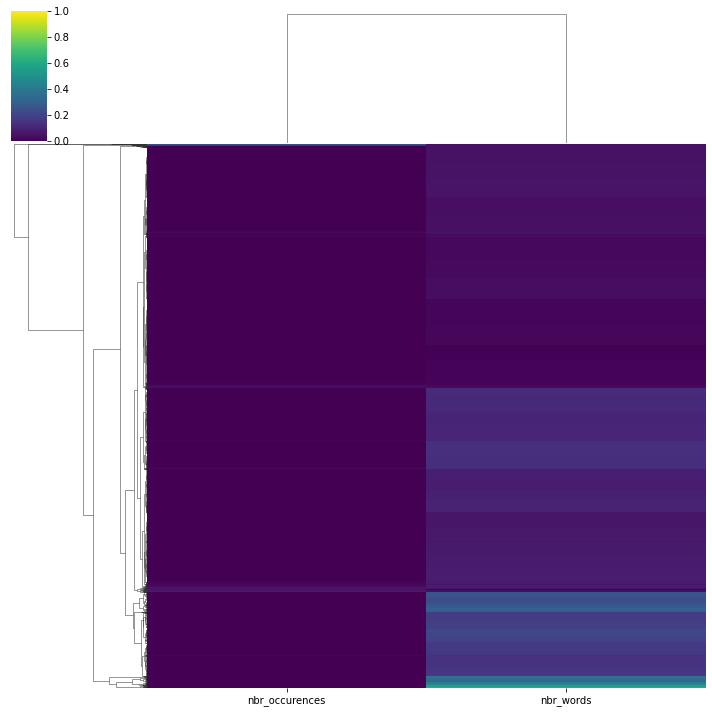

In [27]:
sns.clustermap(clust_df_short, cmap='viridis', yticklabels=False, standard_scale=True)
plt.show()

## Sentiment analysis

In [116]:
#test
analyzer = SentimentIntensityAnalyzer()
idx=88952
vs = analyzer.polarity_scores(df.quote[idx])

print('Negative sentiment:',vs['neg'])
print('Neutral sentiment:',vs['neu'])
print('Positive sentiment:',vs['pos'])
print('Compound sentiment:',vs['compound'])
print(type(vs))

Negative sentiment: 0.0
Neutral sentiment: 1.0
Positive sentiment: 0.0
Compound sentiment: 0.0
<class 'dict'>


In [117]:
analyzer = SentimentIntensityAnalyzer()
polarity_scores=pd.DataFrame()

for n, quote_ in enumerate(df['quote'][0:10000]) :
    vs = analyzer.polarity_scores(quote_)
    polarity_scores=polarity_scores.append(vs,ignore_index=True)
    
    
polarity_scores.head(5)

,compound,neg,neu,pos
0,0.8481,0.0,0.620,0.380
1,0.0000,0.0,1.000,0.000
2,0.7691,0.0,0.693,0.307
3,0.7506,0.0,0.775,0.225
4,0.3919,0.0,0.823,0.177


In [119]:
print(polarity_scores.nlargest(10, 'pos'))
print(polarity_scores.nlargest(10, 'neg'))

      compound  neg    neu    pos
3971    0.8689  0.0  0.093  0.907
1296    0.6705  0.0  0.154  0.846
4961    0.9432  0.0  0.158  0.842
142     0.8720  0.0  0.168  0.832
4876    0.8519  0.0  0.177  0.823
4342    0.7783  0.0  0.204  0.796
754     0.8074  0.0  0.215  0.785
5601    0.7269  0.0  0.220  0.780
8964    0.8807  0.0  0.227  0.773
8102    0.9545  0.0  0.234  0.766
      compound    neg    neu  pos
2759   -0.8860  0.912  0.088  0.0
4890   -0.8689  0.831  0.169  0.0
8263   -0.8402  0.800  0.200  0.0
3723   -0.8225  0.792  0.208  0.0
1945   -0.9274  0.773  0.227  0.0
1458   -0.7717  0.770  0.230  0.0
6941   -0.9531  0.764  0.236  0.0
8186   -0.6597  0.762  0.238  0.0
4523   -0.7452  0.760  0.240  0.0
2785   -0.7351  0.756  0.244  0.0
